# Project Milestone P4 - Creative extension

## Goals

This notebook is a creative extension concerning the article _Comparing Random Forest with Logistic Regression for
Predicting Class-Imbalanced Civil War Onset Data_ by D.Muchlinski et al (2016).

We aim to do 3 tasks :

1. Train new classifiers and compare their performance related to the Random Forest and Logistic Regressions that were tested in the paper.
2. Balance the dataset using the SMOTE to assess how data augmentation and resampling help the predictions of these classifiers.
3. Bringing a new dataset - the Urban Social Disorder (USB) dataset - assess how well the features of the Civil War Dataset (CWD) can predict urban unrest.

## Imports

- Scikit-learn : Scikit will allow us to easily import all the classifiers we want to assess and to compute multiple metrics to compare them
- Numpy : The standard Python library to manipulate matrices
- Pandas : The standard Python library to manipulate datasets
- imblearn : The Imbalance Learn package will allow us to use the SMOTE algorithm
- Matplotlib : It will allow us to produce figures to visualize our results
- Seaborn : It will also allow us to produce figures

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import auc, roc_curve, f1_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
%matplotlib inline

## 1. Data Loading and preparation

We first load the Civil War Dataset (CWD) using the `read_csv` function. Note that we only load the 91 features (stored in the `replication_features` list) that are used in the original paper.

We directly divide this dataset into the feature vectors `X` and the label vector `y`. We then print the number of feature vectors and the first few ones to get a good grasp of their content

In [2]:
replication_features = ["warstds", "ager", "agexp", "anoc", "army85", "autch98", "auto4",
    "autonomy", "avgnabo", "centpol3", "coldwar", "decade1", "decade2",
    "decade3", "decade4", "dem", "dem4", "demch98", "dlang", "drel", "durable",
    "ef", "ef2", "ehet", "elfo", "elfo2", "etdo4590", "expgdp", "exrec",
    "fedpol3", "fuelexp", "gdpgrowth", "geo1", "geo2", "geo34", "geo57",
    "geo69", "geo8", "illiteracy", "incumb", "infant", "inst", "inst3", "life",
    "lmtnest", "ln_gdpen", "lpopns", "major", "manuexp", "milper", "mirps0",
    "mirps1", "mirps2", "mirps3", "nat_war", "ncontig", "nmgdp", "nmdp4_alt",
    "numlang", "nwstate", "oil", "p4mchg", "parcomp", "parreg", "part",
    "partfree", "plural", "plurrel", "pol4", "pol4m", "pol4sq", "polch98",
    "polcomp", "popdense", "presi", "pri", "proxregc", "ptime", "reg",
    "regd4_alt", "relfrac", "seceduc", "second", "semipol3", "sip2", "sxpnew",
    "sxpsq", "tnatwar", "trade", "warhist", "xconst"]

cwd = pd.read_csv('data/SambnisImp.csv', usecols=replication_features)

# Retreiving the labels
y = cwd['warstds']
X = cwd.drop('warstds', axis=1)

print('Nb of country-years: {}'.format(len(X)))
X.head()

Nb of country-years: 7140


,ptime,autonomy,popdense,army85,milper,trade,nmgdp,autch98,demch98,polch98,...,mirps1,mirps2,mirps3,sxpsq,pol4sq,decade1,decade2,decade3,decade4,proxregc
0,12,0.005151,118.554791,129472.9042,121.087366,72.881375,4508.131692,0,0,0,...,0.16935,0.313143,0.373714,0.052989,61.493014,0,0,0,0,0.143299
1,24,0.000000,117.756342,129413.0225,121.885359,72.900089,4491.340308,0,0,0,...,0.00000,1.000000,0.000000,0.052663,100.000000,0,0,0,0,1.000000
2,36,0.000000,118.280656,130431.0145,122.780608,72.962880,4484.267686,0,0,0,...,0.00000,1.000000,0.000000,0.052891,100.000000,0,0,0,0,1.000000
3,48,0.000000,118.325869,126781.6866,118.256427,73.102449,4474.082672,0,0,0,...,0.00000,1.000000,0.000000,0.052902,100.000000,0,0,0,0,1.000000
4,60,0.000000,118.312296,130979.2470,122.245074,72.850389,4497.299503,0,0,0,...,0.00000,1.000000,0.000000,0.052706,100.000000,0,0,0,0,1.000000


Here we simply verify that there are no missing data in the CWD. As the value is 0, it means that there are no missing data.

In [3]:
len(X[X.isna().any(axis=1)])

0

In this extension, we will only use the model of Hegre and Sambanis as it appeared with the first replication that it was the model with the best performance. Thus we have to create new feature vectors only containing the corresponding features.

In [4]:
HS_features = ["lpopns", "ln_gdpen", "inst3", "parreg", "geo34",
    "proxregc", "gdpgrowth", "anoc", "partfree", "nat_war", "lmtnest",
    "decade1", "pol4sq", "nwstate", "regd4_alt", "etdo4590", "milper", "geo1",
    "tnatwar", "presi"]
X_HS = X[HS_features]

## 2. Training and comparing new classifiers

We first create all the classifiers we are going to assess. These can all be imported from Scikit-Learn

* Logistic regression : we choose to only compare the L2-regularized version
* Gradient Boosted Classifier : This is the equivalent of Gradient Boosted Trees
* Random Forest : We create a Random Forest of 1000 trees which have a maximum depth of 100
* Multilayer Perceptron : Our Multilayer Perceptron has a single hidden layer of 100 neurons

In [5]:
logistic_pen = LogisticRegression(penalty='l2', solver='lbfgs', max_iter=10000)
gbc = GradientBoostingClassifier()
random_forest = RandomForestClassifier(n_estimators=1000)
mlp = MLPClassifier(max_iter = 1000)

`draw_roc_on_ax` is a helper function that draws the ROC curve on the given `ax` given the false and true positive rates
* `ax` : the figure to draw the ROC curve on
* `fpr` : the false positive rates
* `tpr` : the true positive rates
* `model name` : the name of the model used to compute the true and false positive rates. This name will be displayed as legend

In [6]:
def draw_roc_on_ax(ax, fpr, tpr, model_name):
    # Compute the area under the fpt-tpf curve
    auc_score = auc(fpr, tpr)
    # Plotting results
    ax.plot(fpr, tpr, label='{}: {:.2f}'.format(model_name, auc_score))

`plot_multi_roc` plots multiple ROC curves on a 10-fold cross-validation given the following parameters :
* titles : the figures' titles
* logistic_methods : a list containing the logistic regression methods to be assessed with a ROC curve
* logistic_models : a list containing the logistic regression models to be assessed with a ROC curve
* logistic_models_names : a list containing the names logistic regression models
* other_classifiers : a list of classifiers to assess alongside the logistic regressions
* other_classifiers : a list of  the names of the classifiers to assess alongside the logistic regressions
* other_classifiers_dataset : the dataset to be used with the other classifiers
* y : the label vector to predict

In [7]:
def plot_multi_roc(titles, logistic_methods, logistic_models, logistic_models_names, other_classifiers, other_classifiers_names, other_classifiers_dataset , y):
    fig, axes = plt.subplots(1,len(logistic_methods), figsize=(len(logistic_methods)*6.5,5))
    
    # Computing random classifiers' prediction only once
    classifiers_y_preds = []
    for classifier_name, classifier in zip(other_classifiers_names, other_classifiers):
        dataset = other_classifiers_dataset
        
        if classifier_name == "Multilayer perceptron":
            scaler = StandardScaler()
            scaler.fit(other_classifiers_dataset)
            dataset = scaler.transform(other_classifiers_dataset)
            
        classifiers_y_preds.append((classifier_name, cross_val_predict(classifier, dataset, y, cv=10, method="predict_proba")))
    
    if(len(logistic_methods)) > 1:
        for ax, title, logistic_method in zip(axes.flatten(), titles, logistic_methods):
            for classifier_name, classifier_y_pred in classifiers_y_preds:
                fpr, tpr, _ = roc_curve(y, classifier_y_pred[:, 1])
                draw_roc_on_ax(ax, fpr, tpr, classifier_name)
            for logistic_model, logistic_model_name in zip(logistic_models, logistic_models_names):
                y_pred = cross_val_predict(logistic_method, logistic_model, y, cv=10, method="predict_proba")
                # Compute the False Positive Rate and True Positive Rate
                fpr, tpr, _ = roc_curve(y, y_pred[:, 1])
                draw_roc_on_ax(ax, fpr, tpr, logistic_model_name)
            ax.set_title(title)
            ax.set_xlabel("False Positive Rate")
            ax.set_ylabel("True Positive Rate")
            ax.legend()
    else:
        for classifier_name, classifier_y_pred in classifiers_y_preds:
            fpr, tpr, _ = roc_curve(y, classifier_y_pred[:, 1])
            draw_roc_on_ax(axes, fpr, tpr, classifier_name)
        for logistic_model, logistic_model_name in zip(logistic_models, logistic_models_names):
            y_pred = cross_val_predict(logistic_methods[0], logistic_model, y, cv=10, method="predict_proba")
            # Compute the False Positive Rate and True Positive Rate
            fpr, tpr, _ = roc_curve(y, y_pred[:, 1])
            draw_roc_on_ax(axes, fpr, tpr, logistic_model_name)
        axes.set_title(titles[0])
        axes.set_xlabel("False Positive Rate")
        axes.set_ylabel("True Positive Rate")
        axes.legend()

With the help of the above function `plot_multi_roc` we can now very easily plot the ROC curve of all classifiers we defined earlier

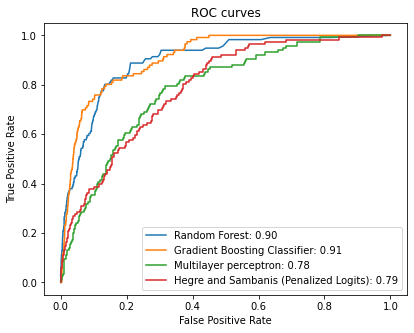

In [8]:
# Methods
titles = ['ROC curves']
logistic_methods = [logistic_pen]

# Models
logistic_models = [X_HS]
logistic_models_names = ['Hegre and Sambanis (Penalized Logits)']

other_classifiers = [random_forest, gbc, mlp]
other_classifiers_names = ["Random Forest", "Gradient Boosting Classifier", "Multilayer perceptron"]


# Fitting models and plotting results
plot_multi_roc(titles, logistic_methods, logistic_models, logistic_models_names, other_classifiers, other_classifiers_names, X, y)

We define the function `compare_models_auc` that performs a Kolmogorov-Smirnov test wheter the AUC of the two input models are statistically different or not. The null hypothesis of this test is that the two distributions are equal.
* model_1 : the first classifier to assess
* model_dataset_1 : the dataset to be used with the first model
* model_2 : the second classifier to assess
* model_dataset_2 : the dataset to be used with the second model
* cv : the number of folds in the cross validation step

In [9]:
def compare_models_aucs(model_1, model_dataset_1, model_2, model_dataset_2, y, cv=10):
    model_1_aucs = cross_val_score(model_1, model_dataset_1, y, cv=cv, scoring="roc_auc")
    model_2_aucs = cross_val_score(model_2, model_dataset_2, y, cv=cv, scoring='roc_auc')
    return stats.kstest(model_1_aucs, model_2_aucs)

We can now use this function to assess if the results we observe in the ROC curves figures are statistically significants. Our first observation is that the Gradient Boosted Classifier is performing a bit better than the random forest (0.01). This is **extremely** likely that the difference is not significant, but for completeness we still compare their distributions

In [10]:
compare_models_aucs(gbc, X, random_forest, X, y)

KstestResult(statistic=0.2, pvalue=0.9944575548290717)

As the p-value is so high (almost 1), it is obvious that we cannot reject the null hypothesis that the 2 distributions are the same and thus we cannot assert that the Gradient Boosted Classifier performs better than the Random Forest.

We will now test if the Gradient Boosted Classifier performs better than the Logistic Regression

In [11]:
compare_models_aucs(gbc, X, logistic_pen, X_HS, y)

KstestResult(statistic=0.7, pvalue=0.012340600575894691)

With a p-value smaller than 0.05, we can reject the null hypothesis that the distributions are different. Thus we can assert that the Gradient Boosted Classifier performs better than the Logistic Regression.

Concerning the MLP, we will not even make statistical tests as it appears obvious that it doesn't perform better than any other classifier

## 3. Resampling data with SMOTE

One second task is to use a resampling technique and study its effect on both the linear models and the random forest. Indeed, it may well be that the poor performance of linear models relative to random forest is due to the severe imbalance of the CWD (roughly a 1:100 ratio).
To tackle this, we intend to use one of the most commonly used oversampling methods: the SMOTE (Synthetic Minority Oversampling Technique).

The SMOTE creates new instances of the minority class, and makes use of the K-nearest neighbors procedure to do so. The algorithm loops through all the "real" minority class instances. At each iteration, it finds its K nearest neighbors, and then creates "synthetic" minority class instances in the interval between the "real" instance and its "real" neighbors, such that the new instances are convex combination of the original instance and one of its neighbors. The procedure can be visualised in the following images ([source](https://rikunert.com/SMOTE_explained)).

<img src="img/SMOTE_1.png" width=600>

<img src="img/SMOTE_2.png" width=600>


In the cell below, we print the number of labels of each class before resampling them. Then we instantiate a SMOTE instance from `imblearn` and use it to resample the data. After this step we reprint the number of labels of each class and now observe that they are the same.

In [12]:
print("Before SMOTE, counts of labels 'warstds' ('1': {}, '0': {}".format(sum(y==1), sum(y==0)))

sm = SMOTE()
X_res, y_res = sm.fit_sample(X, y.ravel())

print("After SMOTE, counts of labels 'warstds' ('1': {}, '0': {}".format(sum(y_res==1), sum(y_res==0)))

Before SMOTE, counts of labels 'warstds' ('1': 116, '0': 7024
After SMOTE, counts of labels 'warstds' ('1': 7024, '0': 7024


We can now test whether training on this newly balanced data is enough to increase the predictive power of the Random Forest and the logistic regression in both normal and L2-penalized versions.

For this, we split our data between a training and testing set, and then proceed to train each model twice: once on the raw training data and once on a SMOTE-resampled version. Both versions of each trained model are then tested on test set, which remained unbalanced. Testing is done by computing the F1 score.

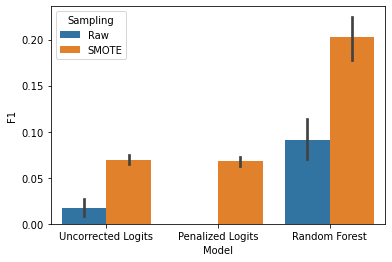

In [13]:
# Creating the methods
logistic = LogisticRegression(penalty='none', solver='lbfgs', max_iter=10000)
logistic_pen = LogisticRegression(penalty='l2', solver='lbfgs', max_iter=10000)
random_forest = RandomForestClassifier(n_estimators=400)

# Methods
methods_names = ['Uncorrected Logits', 'Penalized Logits', 'Random Forest']
methods = [logistic, logistic_pen, random_forest]

def pre_post_SMOTE_score(score, method, model_features, X_train, X_train_sm, y_train, y_train_sm, X_test, y_test):
    """
    Obtain demanded score on test set for model trained on raw data, and for model trained on resampled data
    """
    X_test = X_test[model_features]
    
    # 1. No resampling
    X_train = X_train[model_features]
    F1_raw = score(y_test, method.fit(X_train, y_train).predict(X_test))

    # 2. Using SMOTE
    X_train_sm = X_train_sm[model_features]
    F1_sm = score(y_test, method.fit(X_train_sm, y_train_sm).predict(X_test))    

    return F1_raw, F1_sm


def score_sampling(score, methods, methods_names, nb_repeat):
    """
    Train given methods on raw and SMOTE resampled data and compute score.
    """
    # Storing results
    pd_method = []
    pd_sampling = []
    pd_F1 = []
    
    for method_name, method in zip(methods_names, methods):        
        # Storing F1 scores
        F1s_raw = []
        F1s_sm = []
        
        features = replication_features[1:] if method_name == 'Random Forest' else HS_features
        
        # Filling array
        pd_method.extend([method_name for nb in range(nb_repeat*2)])

        # Each method goes through the same splits
        np.random.seed(23)
        for i in range(nb_repeat):
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

            # Resampling train data with SMOTE
            sm = SMOTE()
            X_train_sm, y_train_sm = sm.fit_sample(X_train, y_train.ravel())
            
            # Compute scores
            F1_raw, F1_sm = pre_post_SMOTE_score(score, method, features, X_train, X_train_sm, y_train, y_train_sm, X_test, y_test)
            
            # Filling arrays
            pd_sampling.append('Raw')
            pd_F1.append(F1_raw)
            pd_sampling.append('SMOTE')
            pd_F1.append(F1_sm)
        
    results = pd.DataFrame(columns=['Model', 'Sampling', 'F1'])
    results['Model'] = pd_method
    results['Sampling'] = pd_sampling
    results['F1'] = pd_F1
    sns.barplot(x='Model', y='F1', hue='Sampling', data=results)
    return results

results = score_sampling(f1_score, methods, methods_names, nb_repeat=40)

From the above graph, we observe that the usage of SMOTE indeed improved the F1-Score of each classifier, and that each improvement is statistically significant. However, one should notice that these F1-scores are still low (below 0.2) and thus the predictions are still not very accurate.

# Urban Social Disorder extension

For the third task of this extension, we will explore how well the features of the CWD can predict a measure of urban unrest taken from the Urban Social Disorder (USD) dataset ([source](https://www.prio.org/Data/Armed-Conflict/Urban-Social-Disorder/)). This dataset is detailed more extensively in the report.

## Loading the data

We load the dataset using pandas' `read_excel` method. We will only use three columns : 

* GWNO : code of a country. It is equivalent to the column `cowcode` of the CWD
* BYEAR : the beginning year of the event
* PTYPE : The "Problem Type" of the event. Description from the codebook :
Identifies the general level and type of event according to the following list of values.
While the PTYPE variable is considered to be a nominal variable, it is structured
with some sense of ordinal ranking of societal conflict magnitude (based on degree
of institutionalization of political activity).
    * 10 General Warfare
    * 20 Inter-communal Warfare
    * 30 Armed Battle/Clash
    * 31 Armed Attack
    * 40 Pro-Government Terrorism (Repression)
    * 41 Anti-Government Terrorism
    * 42 Communal Terrorism
    * 50 Organized Violent Riot
    * 51 Spontaneous Violent Riot
    * 60 Organized Demonstration
    * 61 Pro-Government Demonstration
    * 62 Spontaneous Demonstration
    * 70 Other
    
The `GWNO` and `BYEAR` will help us to merge this dataset with the CWD and the `PTYPE` will make the measure of urban unrest.


For this extension, we will not care about Problem types 60, 61, 62, 70 as these are peaceful events. We want instead to focus on the violent ones. Moreover, as we only care to measure whether there has been any social unrest during a particular year, we can drop all duplicates with respect to the year and country code. As the CWD ends in 2000, we can also crop the USD at that time.
Finally, we add a new column that will contain a dummy variable. A 1 indicates that there has been some social unrest in this country during this particular year.

In [14]:
usd = pd.read_excel("data/events.xlsx", usecols = ["GWNO", "BYEAR", "PTYPE"])
usd = usd[usd["PTYPE"].isin([60, 61, 62]) == False].drop_duplicates(subset=["BYEAR", "GWNO"])
usd = usd[usd['BYEAR'] <= 2000]
usd["social_unrest"] = 1
usd.head(5)

,GWNO,PTYPE,BYEAR,social_unrest
5,437,51,1985,1
10,437,31,1990,1
16,437,31,1991,1
19,437,31,1993,1
24,437,51,1995,1


To merge the CWD with the PRIO dataset, we need to add the `cowcode` and `year` features to the CWD. Hence we have to reload it with these new features.

Then we can merge the two datasets. before doing so, we crop the CWD to not consider the data before 1960 as this is the starting date of the USD. Then, as we wish to keep all entry points of the CWD, we perform a left join. The NaN values are set to 0 as it means that there was no conflict in a year in a country.

In [15]:
cwd = pd.read_csv('data/SambnisImp.csv', usecols=(replication_features + ["cowcode", "year"]))
cwd_and_usd = pd.merge(cwd[cwd["year"] >= 1960], usd, left_on = ["cowcode", "year"], right_on = ["GWNO", "BYEAR"], how="left").drop(["GWNO", "BYEAR", "cowcode", "year", "PTYPE"], axis = 1).fillna(0)
cwd_and_usd.head(5)

,warstds,ptime,autonomy,popdense,army85,milper,trade,nmgdp,autch98,demch98,...,mirps2,mirps3,sxpsq,pol4sq,decade1,decade2,decade3,decade4,proxregc,social_unrest
0,0,192,0.0,117.804310,129057.9163,118.807096,72.699552,1383.666626,0,0,...,1.0,0.0,0.052972,100.0,1,0,0,0,3.010000e-36,0.0
1,0,204,0.0,15.661860,47000.0000,60.000000,11.157030,1324.000000,0,0,...,1.0,0.0,0.052912,100.0,1,0,0,0,7.520000e-37,0.0
2,0,216,0.0,15.982750,47000.0000,77.000000,12.550610,1351.333374,0,0,...,1.0,0.0,0.052754,100.0,1,0,0,0,1.880000e-37,0.0
3,0,228,0.0,16.321039,47000.0000,90.000000,14.227640,1366.333374,0,0,...,1.0,0.0,0.052624,100.0,1,0,0,0,4.700000e-38,0.0
4,0,240,0.0,16.675520,47000.0000,100.000000,26.035509,1451.333374,0,0,...,1.0,0.0,0.052699,100.0,1,0,0,0,1.180000e-38,0.0


Let's just see the distributions of entries that have social unrest

In [16]:
cwd_and_usd["social_unrest"].value_counts()

0.0    4677
1.0    1285
Name: social_unrest, dtype: int64

One fear of this extension was that social unrest was extremely correlated with civil war onsets. This would have meant that making predictions on this new feature would have brought nothing new. Hopefully the cell below shows that the correlation between the two is very weak.

In [18]:
cwd_and_usd["warstds"].corr(cwd_and_usd["social_unrest"])

0.08735761277661097

Finally, we are able to assess the predictions of all of our classifiers for the social unrest feature. For that, we again plot the ROC curves.

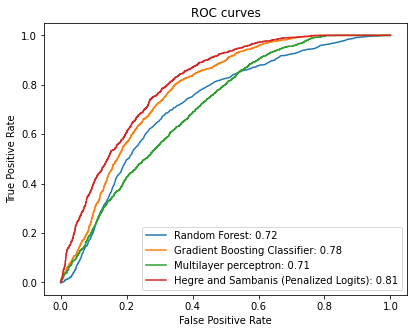

In [19]:
#Hegre and Sambanis (2006) 
X_HS_unrest  =  cwd_and_usd[HS_features]

X_unrest = cwd_and_usd.drop(["social_unrest", "warstds"], axis = 1)
y_unrest = cwd_and_usd["social_unrest"]

# Methods
titles = ['ROC curves']
logistic_methods = [logistic_pen]

# Models
logistic_models = [X_HS_unrest]
logistic_models_names = ['Hegre and Sambanis (Penalized Logits)']

other_classifiers = [random_forest, gbc, mlp]
other_classifiers_names = ["Random Forest", "Gradient Boosting Classifier", "Multilayer perceptron"]


# Fitting models and plotting results
plot_multi_roc(titles, logistic_methods, logistic_models, logistic_models_names, other_classifiers, other_classifiers_names, X_unrest, y_unrest)

From the above plot, we observe that all classifiers perform somewhat similarly for this prediction, but that the predictions are overall not very good with the best AUC at 0.81. Surprisingly, this best AUC is achieved by the Linear Regression model of Hegre and Sambanis